# Overview
- 移動特徴量(mean, std, min, max)を使ってみる
- nb001 のときは、mv_mean だけ使った。その時のスコアは、cv: 0.3712だった

# Const

In [1]:
NB = '005'
isSmallSet = False
LENGTH = 1000

PATH_TRAIN = './../data/input/train.csv'
PATH_TEST = './../data/input/test.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from dtreeviz.trees import dtreeviz

# My function

In [3]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
def get_signal_mv_mean(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_std(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).std().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_min(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).min().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_max(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).max().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
#         plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Preparation

setting

In [4]:
sns.set()

<br>

load dataset

In [5]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [6]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

smallset?

In [7]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# Experiments
- 移動特徴量を作成

移動平均を計算

In [8]:
for _df in [df_tr, df_te]:
    _df['signal_mv_mean'] = get_signal_mv_mean(_df, n=3001)
    _df['signal_mv_std'] = get_signal_mv_std(_df, n=3001)
    _df['signal_mv_min'] = get_signal_mv_min(_df, n=3001)
    _df['signal_mv_max'] = get_signal_mv_max(_df, n=3001)

<br>

train 

In [9]:
df_tr.columns

Index(['time', 'signal', 'open_channels', 'batch', 'signal_mv_mean',
       'signal_mv_std', 'signal_mv_min', 'signal_mv_max'],
      dtype='object')

In [10]:
X = df_tr.drop(['time', 'open_channels', 'batch'], axis=1)
y = df_tr['open_channels']
X_te = df_te.drop(['time', 'batch'], axis=1)

In [26]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

    folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        test_pred = model.predict(X_te, model.best_iteration_)

        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi_result = pi.df_result

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += test_pred
        df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        plt.figure()
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(test_pred).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof

In [18]:
# Configuration
N_ESTIMATORS = 200          # 最大学習回数
# N_ESTIMATORS = 20          # 最大学習回数
VERBOSE = 50               # 300回ごとに評価する
EARLY_STOPPING_ROUNDS = 30  # 200回の学習でよくならなければ、学習をとめる
N_JOBS = multiprocessing.cpu_count() - 2
N_FOLD = 4
KFOLD_SEED = 0

# lgbm_params
lgbm_params = {'objective': 'huber',
              "metric": 'mae',
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.1,
              "boosting_type": "gbdt",
              'learning_rate': 2,
              'n_jobs': N_JOBS,
# #               "subsample_freq": 1,
# #               "subsample": 1,
#               "bagging_seed": 2,
# #               "verbosity": -1,
#     'num_leaves': 51, 'max_depth': 158, 'min_chiled_samples': 15, 'min_chiled_weight': 1, 'learning_rate': 0.07, 'colsample_bytree': 0.8
             }

features(5): 
Index(['signal', 'signal_mv_mean', 'signal_mv_std', 'signal_mv_min',
       'signal_mv_max'],
      dtype='object')

------------------
- Fold 1/4 started at Sat Apr 25 11:47:37 2020
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 0.328977	valid_1's l1: 0.329166
[100]	training's l1: 0.298828	valid_1's l1: 0.298954
[150]	training's l1: 0.281872	valid_1's l1: 0.282067
[200]	training's l1: 0.267481	valid_1's l1: 0.267635
Did not meet early stopping. Best iteration is:
[200]	training's l1: 0.267481	valid_1's l1: 0.267635
---> f1-score(macro) valid: 0.6314


------------------
- Fold 2/4 started at Sat Apr 25 11:48:34 2020
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 0.319108	valid_1's l1: 0.319061
[100]	training's l1: 0.289866	valid_1's l1: 0.289944
[150]	training's l1: 0.275468	valid_1's l1: 0.275507
[200]	training's l1: 0.263495	valid_1's l1: 0.263829
Did not meet early stopping. Best iteration is:
[200]	t

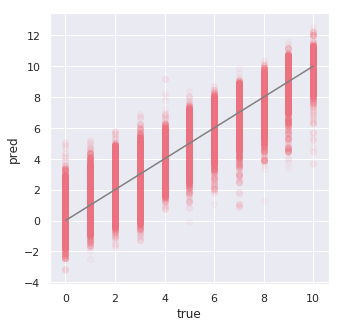

<Figure size 1080x72 with 0 Axes>

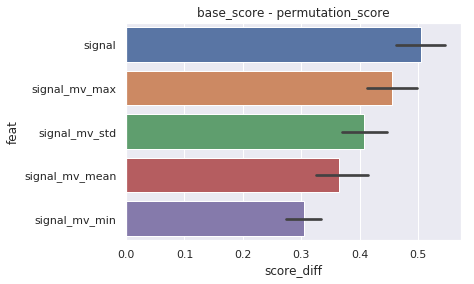

CPU times: user 20min 40s, sys: 1.32 s, total: 20min 41s
Wall time: 4min 45s


In [19]:
%%time
test_pred_round, test_pred, oof_round, oof = train_lgbm(X, y, X_te, lgbm_params,
                                                        n_fold=N_FOLD, 
                                                        verbose=VERBOSE, 
                                                        random_state=KFOLD_SEED, 
                                                        early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                                                        show_fig=True
                                                       )

# Experiments(comparison of moving window size)
- mv特徴量が効くということがわかったので、window_size の比較を行う

In [23]:
window_size_list = [5, 21, 251, 1001, 3001, 5001, 8001]



::window_size = 5::
====== finish ======
score list: [0.32981864982195, 0.303814266735738, 0.3046835052306534, 0.3062362072074584]
CV mean score(f1_macro): 0.3111, std: 0.0108
oof score(f1_macro): 0.2972



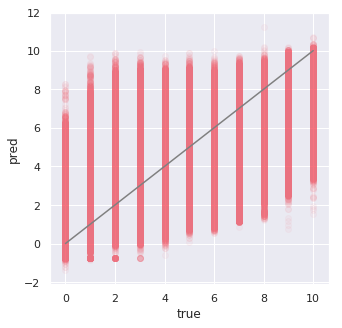

<Figure size 1080x72 with 0 Axes>

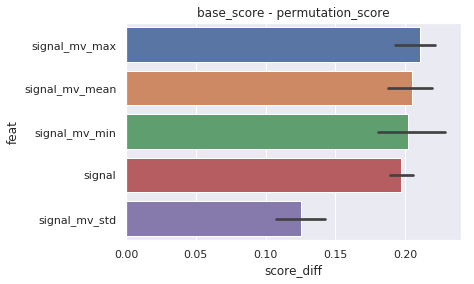



::window_size = 21::
====== finish ======
score list: [0.3328994599715313, 0.3334467884044555, 0.3562015327072849, 0.3140221629632908]
CV mean score(f1_macro): 0.3341, std: 0.0149
oof score(f1_macro): 0.3062



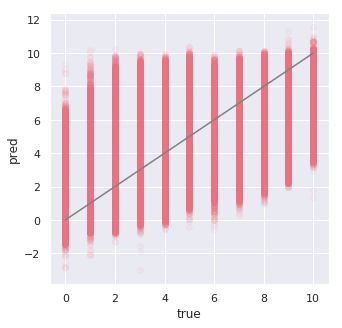

<Figure size 1080x72 with 0 Axes>

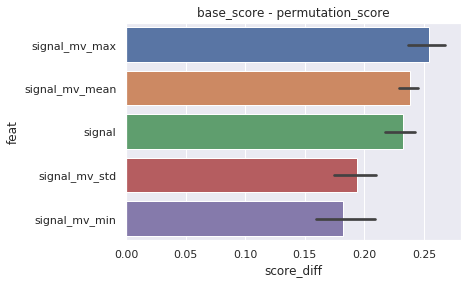



::window_size = 251::
====== finish ======
score list: [0.4224301864217716, 0.45177020114659705, 0.4965941836975395, 0.4148535784705248]
CV mean score(f1_macro): 0.4464, std: 0.0321
oof score(f1_macro): 0.3842



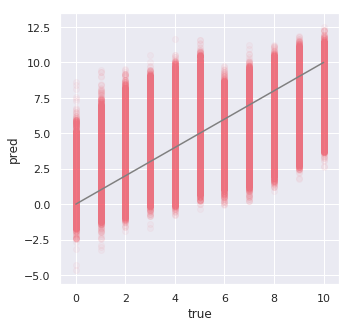

<Figure size 1080x72 with 0 Axes>

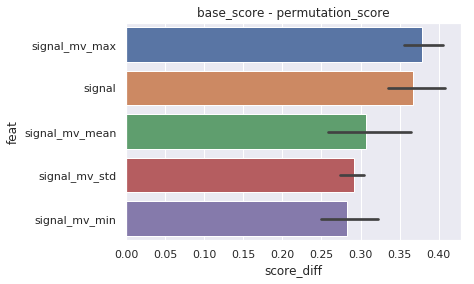



::window_size = 1001::
====== finish ======
score list: [0.4960531159976636, 0.47532633510087574, 0.5238818287192287, 0.5259601652673384]
CV mean score(f1_macro): 0.5053, std: 0.0210
oof score(f1_macro): 0.4612



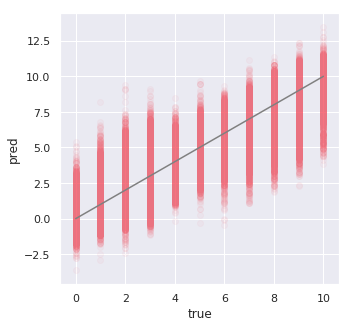

<Figure size 1080x72 with 0 Axes>

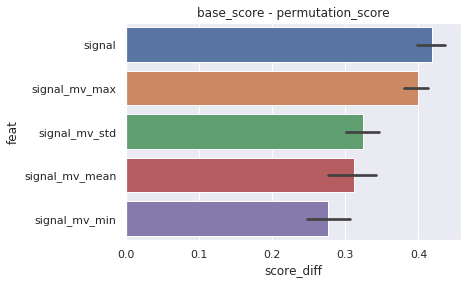



::window_size = 3001::
====== finish ======
score list: [0.6314366306229388, 0.5906204161115268, 0.5323426006329383, 0.5484229365355024]
CV mean score(f1_macro): 0.5757, std: 0.0386
oof score(f1_macro): 0.5130



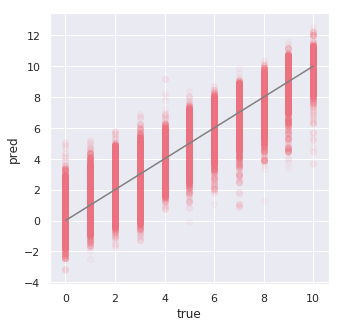

<Figure size 1080x72 with 0 Axes>

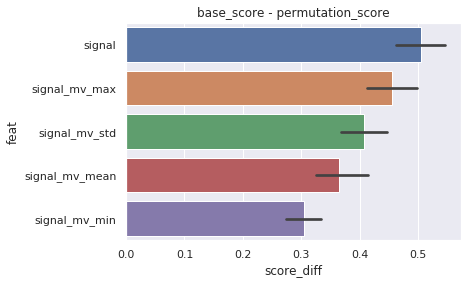



::window_size = 5001::
====== finish ======
score list: [0.5543351781900302, 0.5515729067040636, 0.5532869513677925, 0.5497417366954933]
CV mean score(f1_macro): 0.5522, std: 0.0017
oof score(f1_macro): 0.5522



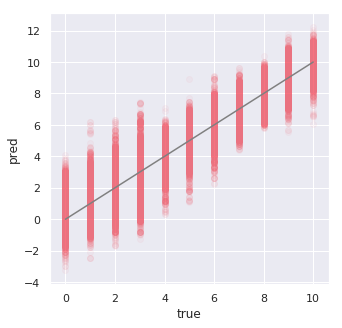

<Figure size 1080x72 with 0 Axes>

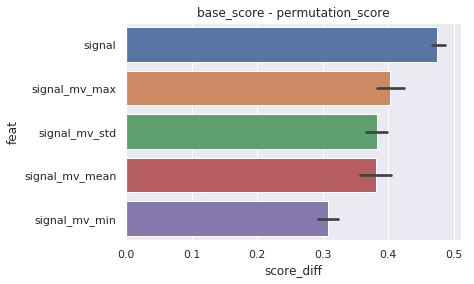



::window_size = 8001::
====== finish ======
score list: [0.5923487012812367, 0.5589611893179673, 0.5361937959419905, 0.5210327951300255]
CV mean score(f1_macro): 0.5521, std: 0.0269
oof score(f1_macro): 0.5170



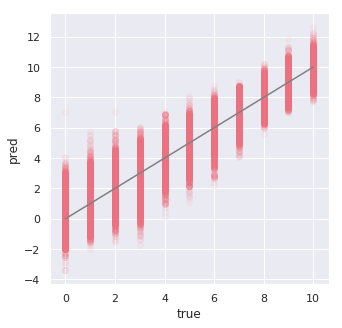

<Figure size 1080x72 with 0 Axes>

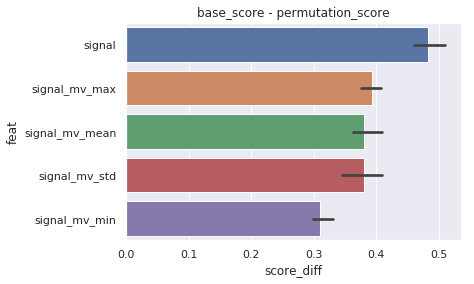

CPU times: user 2h 26min 25s, sys: 10.1 s, total: 2h 26min 35s
Wall time: 34min 59s


In [27]:
%%time
oof_round_list = []
for window_size in window_size_list:
    print(f'\n\n::window_size = {window_size}::')
    _df = df_tr.copy()
    _df['signal_mv_mean'] = get_signal_mv_mean(_df, n=window_size)
    _df['signal_mv_std'] = get_signal_mv_std(_df, n=window_size)
    _df['signal_mv_min'] = get_signal_mv_min(_df, n=window_size)
    _df['signal_mv_max'] = get_signal_mv_max(_df, n=window_size)
    X = _df.drop(['time', 'open_channels', 'batch'], axis=1)
    test_pred_round, test_pred, oof_round, oof = train_lgbm(X, y, X_te, lgbm_params,
                                                            n_fold=N_FOLD, 
                                                            verbose=0, 
                                                            random_state=KFOLD_SEED, 
                                                            early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                                                            show_fig=True
                                                           )
    oof_round_list.append(oof_round)

<br>
スコア比較 

Text(0.5, 0, 'window_size')

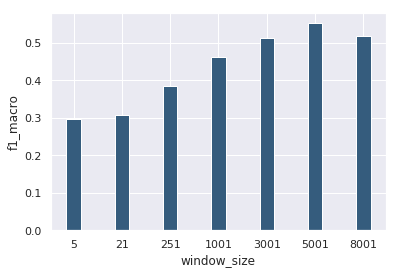

In [28]:
x = np.arange(len(window_size_list))
f1_macro_list = []
for i in range(len(window_size_list)):
    f1_macro_list.append(f1_macro(y, oof_round_list[i]))
    
plt.bar(x, f1_macro_list, color=cp[4], width=0.3)
plt.xticks(x, window_size_list)
plt.ylabel('f1_macro')
plt.xlabel('window_size')

# Experiments(window_size=5001)
- window_sizeは5001がいいことがわかったのでそれで計算する

移動平均を計算

In [41]:
window_size = 5001
for _df in [df_tr, df_te]:
    _df['signal_mv_mean'] = get_signal_mv_mean(_df, n=window_size)
    _df['signal_mv_std'] = get_signal_mv_std(_df, n=window_size)
    _df['signal_mv_min'] = get_signal_mv_min(_df, n=window_size)
    _df['signal_mv_max'] = get_signal_mv_max(_df, n=window_size)

<br>

train 

In [42]:
df_tr.columns

Index(['time', 'signal', 'open_channels', 'batch', 'signal_mv_mean',
       'signal_mv_std', 'signal_mv_min', 'signal_mv_max'],
      dtype='object')

In [43]:
X = df_tr.drop(['time', 'open_channels', 'batch'], axis=1)
y = df_tr['open_channels']
X_te = df_te.drop(['time', 'batch'], axis=1)

In [44]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

    folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        test_pred = model.predict(X_te, model.best_iteration_)

        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi_result = pi.df_result

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += test_pred
        df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        plt.figure()
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(test_pred).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof

In [45]:
# Configuration
N_ESTIMATORS = 200          # 最大学習回数
# N_ESTIMATORS = 20          # 最大学習回数
VERBOSE = 50               # 300回ごとに評価する
EARLY_STOPPING_ROUNDS = 30  # 200回の学習でよくならなければ、学習をとめる
N_JOBS = multiprocessing.cpu_count() - 2
N_FOLD = 4
KFOLD_SEED = 0

# lgbm_params
lgbm_params = {'objective': 'huber',
              "metric": 'mae',
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.1,
              "boosting_type": "gbdt",
              'learning_rate': 2,
              'n_jobs': N_JOBS,
# #               "subsample_freq": 1,
# #               "subsample": 1,
#               "bagging_seed": 2,
# #               "verbosity": -1,
#     'num_leaves': 51, 'max_depth': 158, 'min_chiled_samples': 15, 'min_chiled_weight': 1, 'learning_rate': 0.07, 'colsample_bytree': 0.8
             }

features(5): 
Index(['signal', 'signal_mv_mean', 'signal_mv_std', 'signal_mv_min',
       'signal_mv_max'],
      dtype='object')

------------------
- Fold 1/4 started at Sat Apr 25 23:29:50 2020
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 0.315249	valid_1's l1: 0.315285
[100]	training's l1: 0.289381	valid_1's l1: 0.289512
[150]	training's l1: 0.271575	valid_1's l1: 0.271864
[200]	training's l1: 0.258112	valid_1's l1: 0.258423
Did not meet early stopping. Best iteration is:
[200]	training's l1: 0.258112	valid_1's l1: 0.258423
---> f1-score(macro) valid: 0.5543


------------------
- Fold 2/4 started at Sat Apr 25 23:30:50 2020
Training until validation scores don't improve for 30 rounds
[50]	training's l1: 0.317256	valid_1's l1: 0.317366
[100]	training's l1: 0.288547	valid_1's l1: 0.288935
[150]	training's l1: 0.270477	valid_1's l1: 0.271084
[200]	training's l1: 0.255102	valid_1's l1: 0.255751
Did not meet early stopping. Best iteration is:
[200]	t

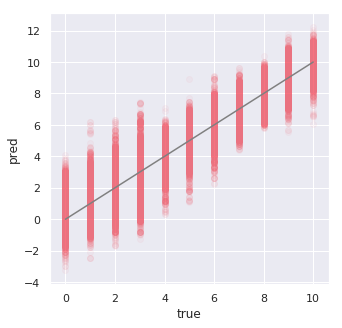

<Figure size 1080x72 with 0 Axes>

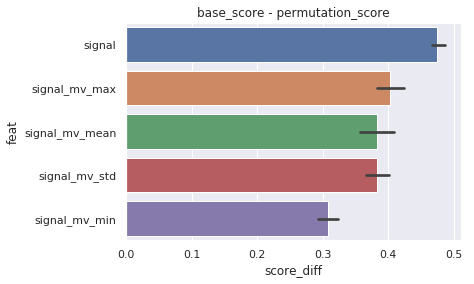

CPU times: user 20min 51s, sys: 2.67 s, total: 20min 54s
Wall time: 4min 48s


In [46]:
%%time
test_pred_round, test_pred, oof_round, oof = train_lgbm(X, y, X_te, lgbm_params,
                                                        n_fold=N_FOLD, 
                                                        verbose=VERBOSE, 
                                                        random_state=KFOLD_SEED, 
                                                        early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                                                        show_fig=True
                                                       )

# save

In [50]:
save_path = f'{DIR_OUTPUT}submission_nb{NB}_cv_{f1_macro(y, oof_round):.4f}.csv'
sub = pd.read_csv(PATH_SMPLE_SUB)
sub['open_channels'] = test_pred_round
print(f'save path: {save_path}')

save path: ./../data/output/submission_nb005_cv_0.5522.csv


In [51]:
sub.to_csv(save_path, index=False, float_format='%.4f')